In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [30]:
# !pip install lightgbm xgboost 

!pip install lightgbm
!pip install xgboost

import lightgbm as lgb
import xgboost as xgb

In [31]:
# Load Data Set

df = pd.read_csv("D:\movies\Basic stats - 1\diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
# EDA
# Check missing values
missing = df.isnull().sum()
print("Missing values per column:\n", missing)

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [33]:
# Summary statistics
display(df.describe(include='all'))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


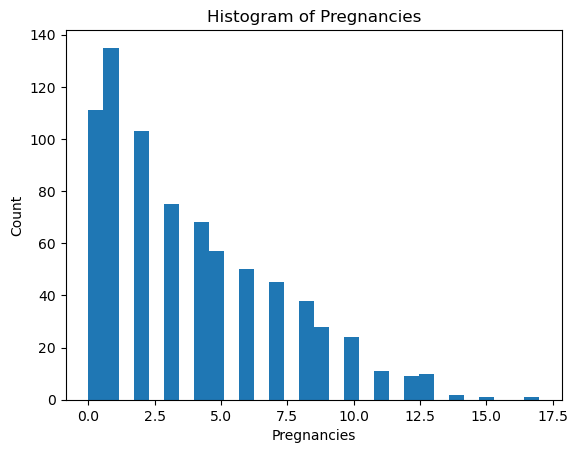

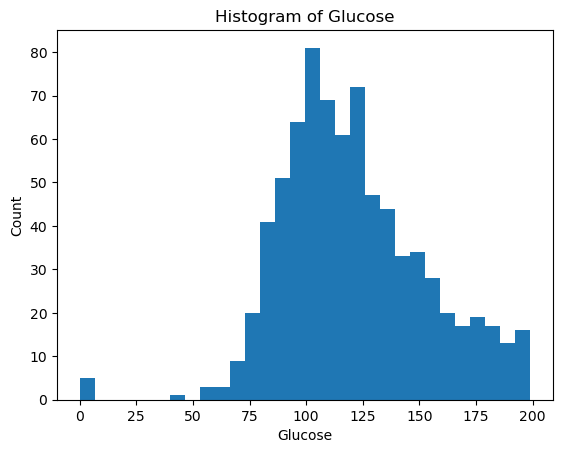

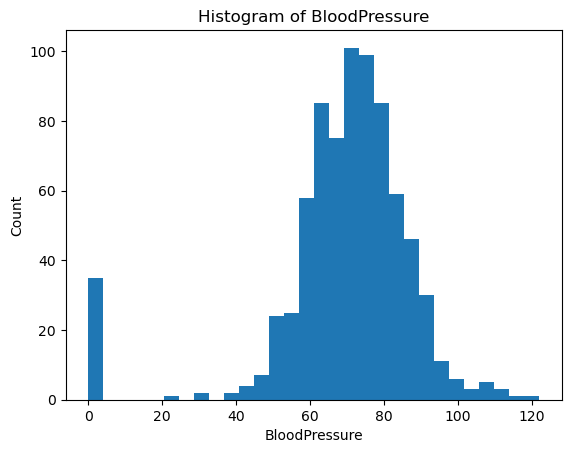

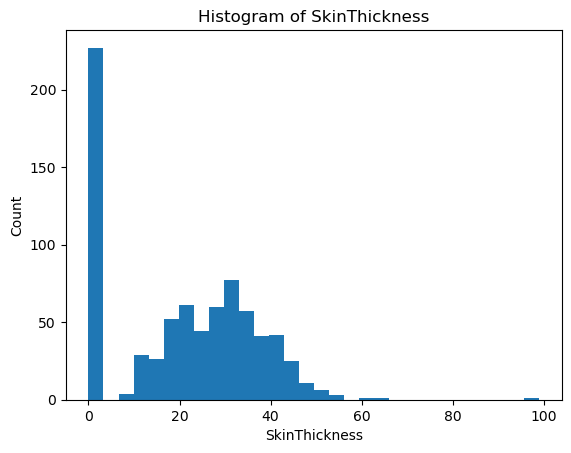

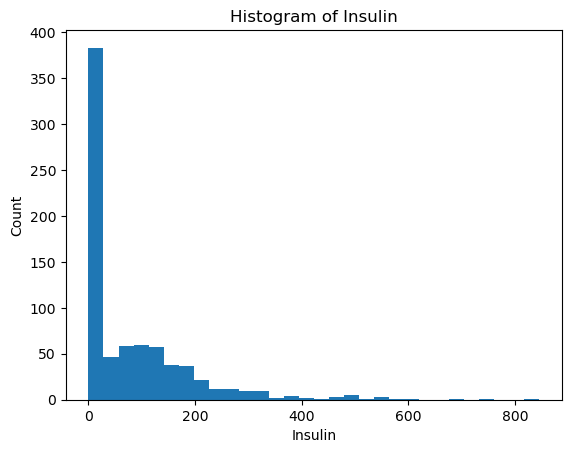

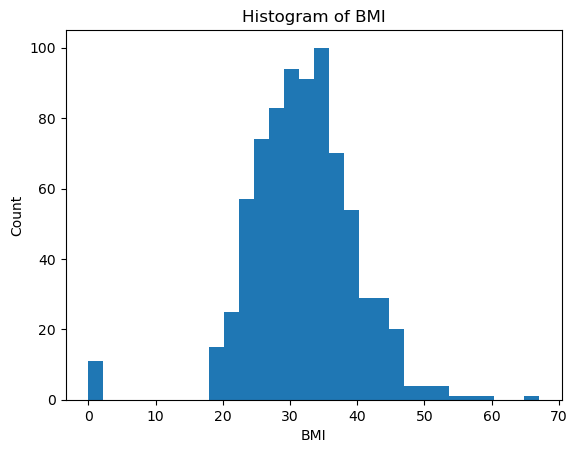

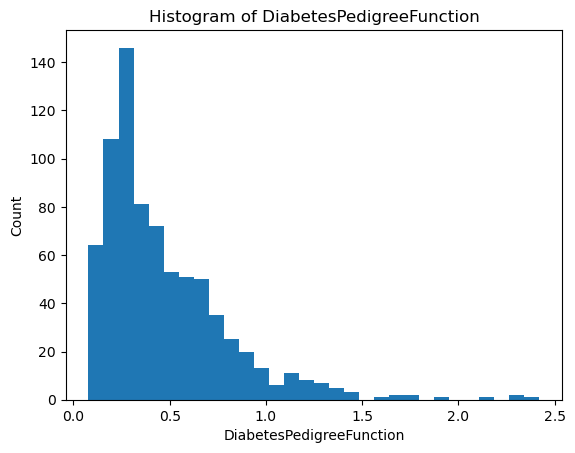

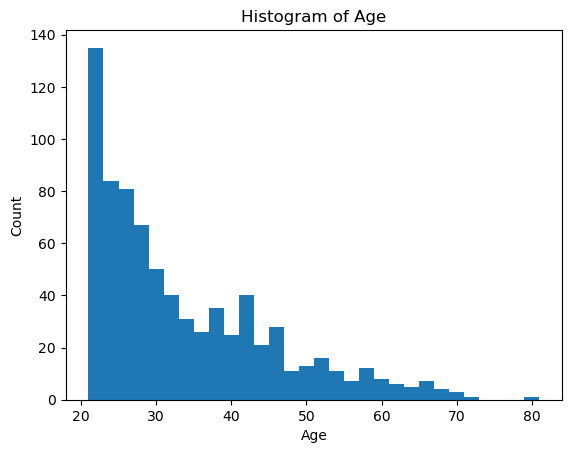

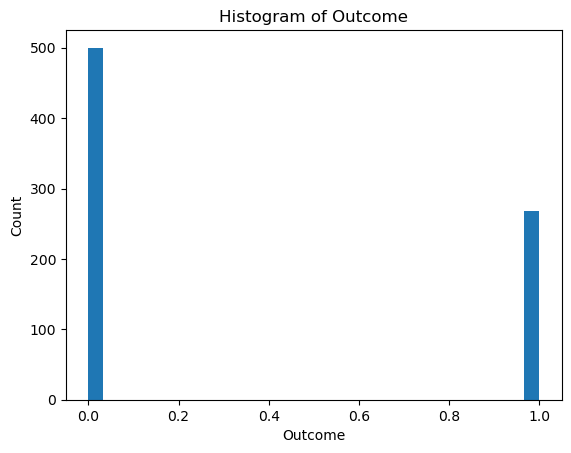

In [34]:
# Histograms for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
 plt.figure()
 plt.hist(df[col].dropna(), bins=30)
 plt.title(f'Histogram of {col}')
 plt.xlabel(col)
 plt.ylabel('Count')
 plt.show()

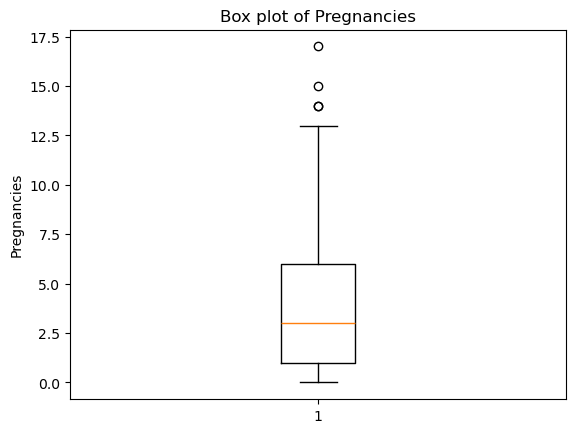

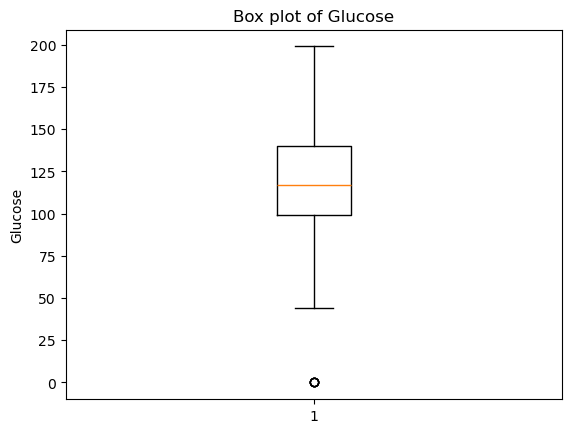

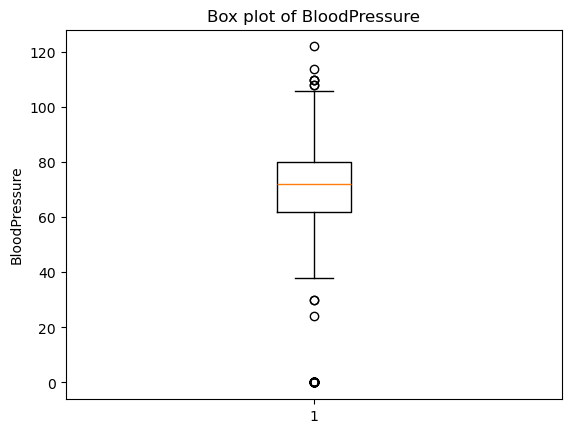

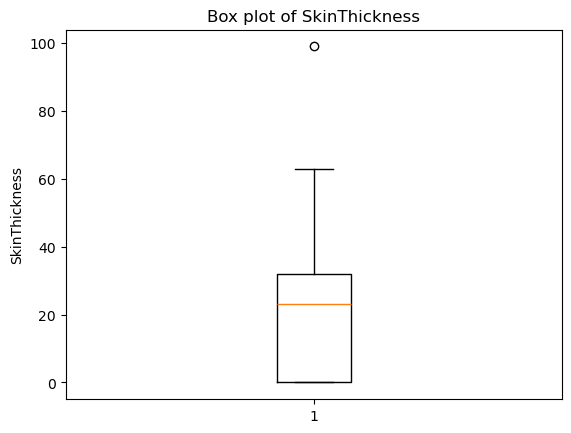

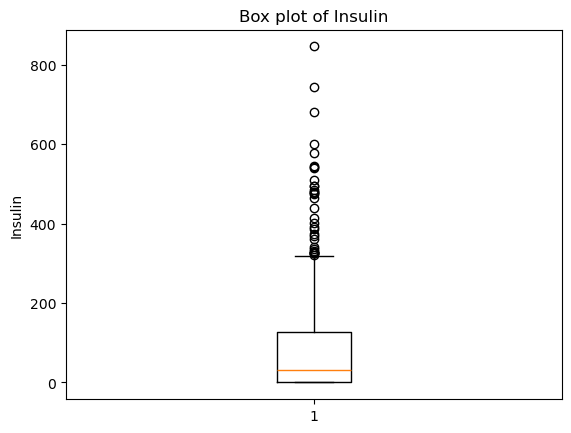

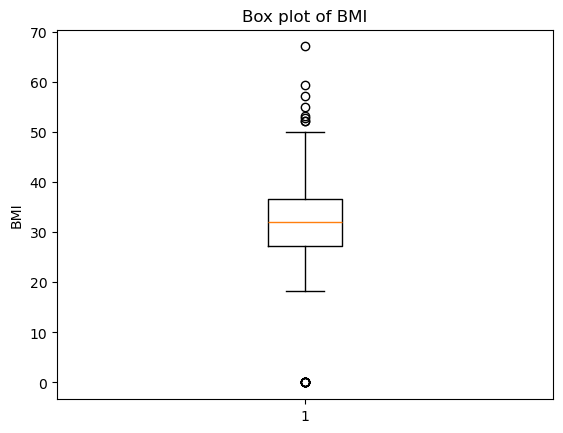

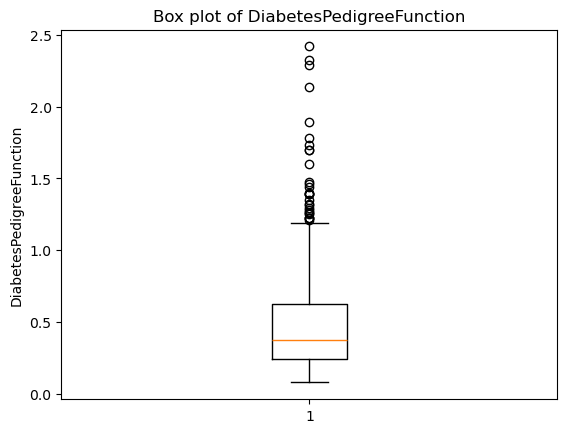

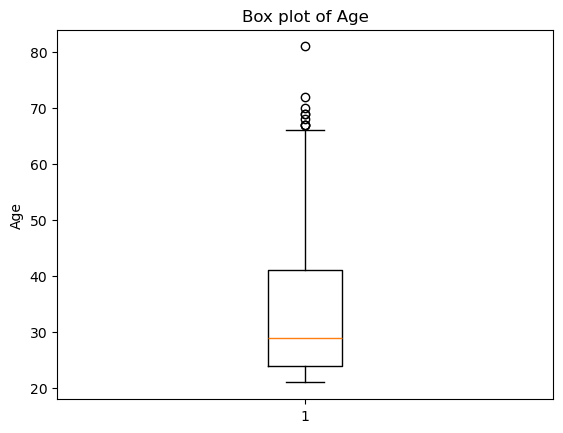

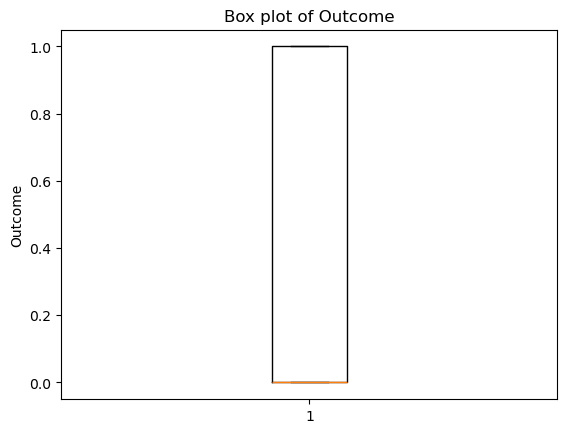

In [35]:
# Box plots for numeric features
for col in numeric_cols:
 plt.figure()
 plt.boxplot(df[col].dropna())
 plt.title(f'Box plot of {col}')
 plt.ylabel(col)
 plt.show()

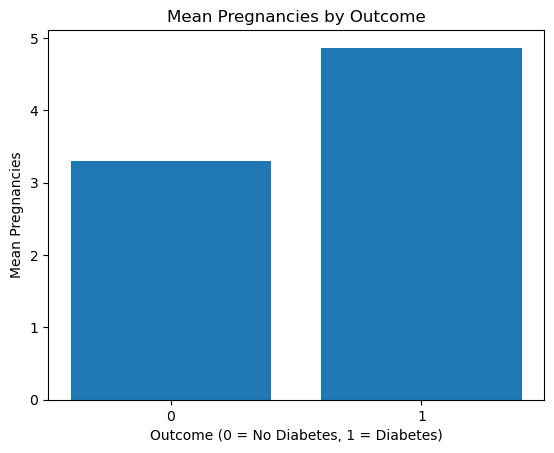

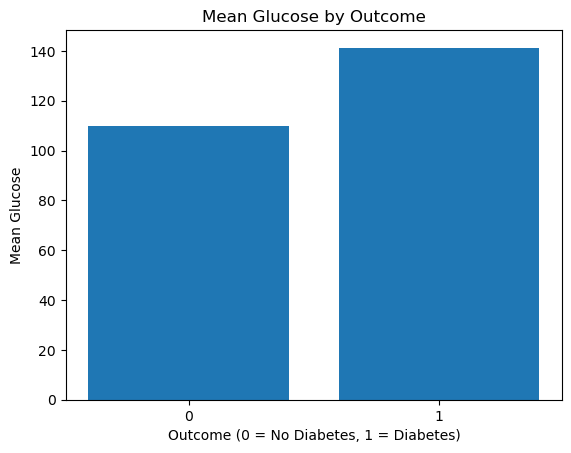

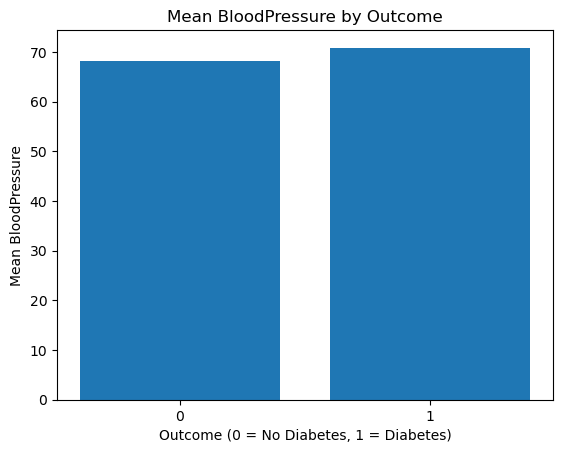

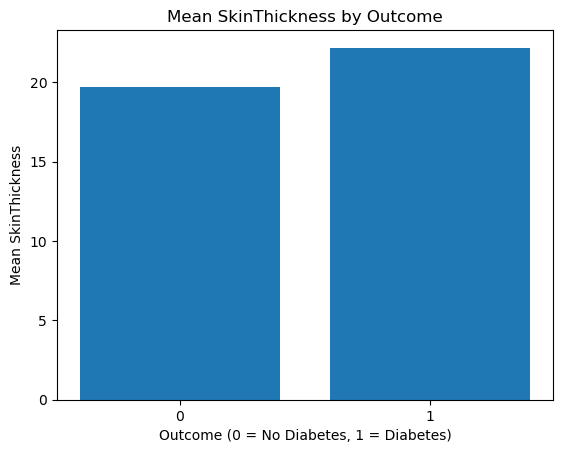

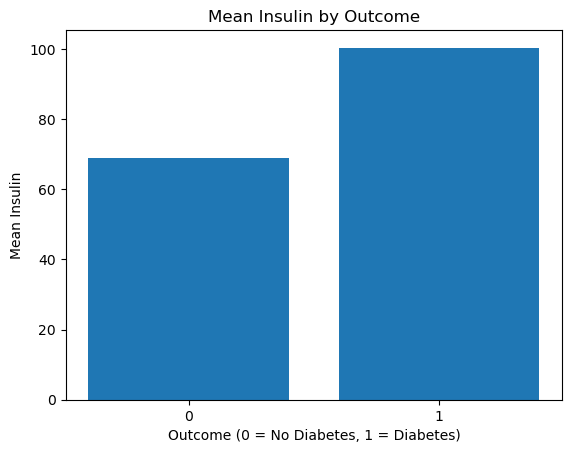

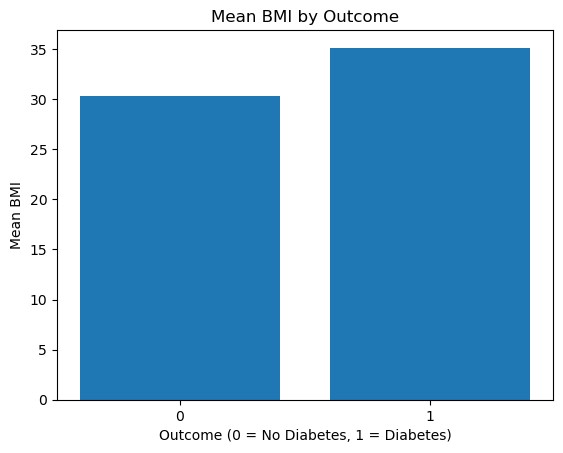

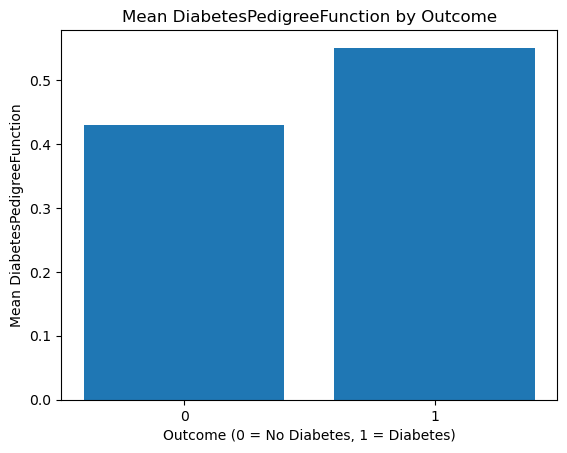

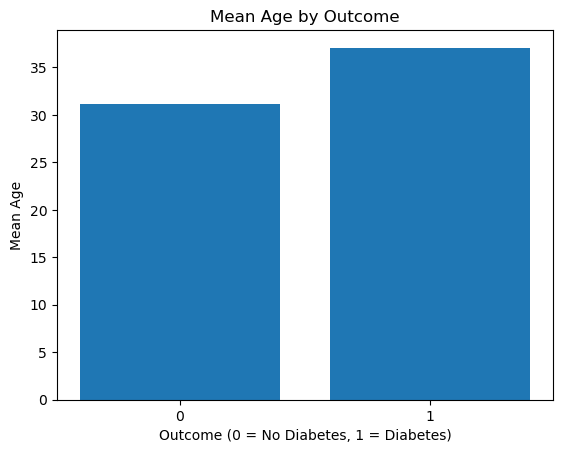

In [36]:
# Bar plots for categorical features vs Survival
import matplotlib.pyplot as plt

# Define all numeric columns except the target
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Loop and create bar plots
for col in num_cols:
    plt.figure()
    grouped = df.groupby('Outcome')[col].mean()
    plt.bar(grouped.index.astype(str), grouped.values)
    plt.title(f'Mean {col} by Outcome')
    plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
    plt.ylabel(f'Mean {col}')
    plt.show()



In [37]:
# 3) Data Preprocessing

from sklearn.preprocessing import StandardScaler


# Replace zeros with NaN for biologically impossible values
zero_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_as_missing] = df[zero_as_missing].replace(0, np.nan)


# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df[zero_as_missing] = imputer.fit_transform(df[zero_as_missing])


# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']


# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


print("Preprocessing complete.")
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

Preprocessing complete.
X_train shape: (614, 8) X_test shape: (154, 8)


In [38]:
# 4) Build and Train LightGBM and XGBoost Models

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----- LightGBM -----
lgb_clf = lgb.LGBMClassifier(random_state=42)

print("\nLightGBM CV Accuracy:")
lgb_scores = cross_val_score(lgb_clf, X_train, y_train, cv=cv, scoring="accuracy")
print(lgb_scores)
print("Mean Accuracy:", np.mean(lgb_scores))

# ----- XGBoost (Clean, No Warnings) -----
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",  # REQUIRED (prevents warnings)
    random_state=42
)

print("\nXGBoost CV Accuracy:")
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring="accuracy")
print(xgb_scores)
print("Mean Accuracy:", np.mean(xgb_scores))




LightGBM CV Accuracy:
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[0.74796748 0.77235772 0.81300813 0.68292683 0.73770492]
Mean Accuracy: 0.7507930161268825


In [39]:
# Hyperparameter Tuning


# %%
lgb_param_grid = {
'n_estimators': [50, 100, 200],
'num_leaves': [15, 31],
'max_depth': [-1, 6, 10]
}


xgb_param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [3, 6, 10],
'learning_rate': [0.01, 0.1, 0.2]
}


lgb_grid = GridSearchCV(lgb_clf, lgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_train, y_train)
print('Best LightGBM params:', lgb_grid.best_params_)


xgb_grid = GridSearchCV(xgb_clf, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print('Best XGBoost params:', xgb_grid.best_params_)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\Lenovo\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [40]:
# Evaluate on Test Set


# %%
best_lgb = lgb_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_


y_pred_lgb = best_lgb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)


def print_metrics(y_true, y_pred, model_name='Model'):
 print(f"Metrics for {model_name}:")
 print('Accuracy:', accuracy_score(y_true, y_pred))
 print('Precision:', precision_score(y_true, y_pred))
 print('Recall:', recall_score(y_true, y_pred))
 print('F1-score:', f1_score(y_true, y_pred))
 print('\nClassification Report:\n', classification_report(y_true, y_pred))


print_metrics(y_test, y_pred_lgb, 'LightGBM')
print_metrics(y_test, y_pred_xgb, 'XGBoost')

Metrics for LightGBM:
Accuracy: 0.7727272727272727
Precision: 0.6938775510204082
Recall: 0.6296296296296297
F1-score: 0.6601941747572816

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       100
           1       0.69      0.63      0.66        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

Metrics for XGBoost:
Accuracy: 0.7467532467532467
Precision: 0.6744186046511628
Recall: 0.5370370370370371
F1-score: 0.5979381443298969

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


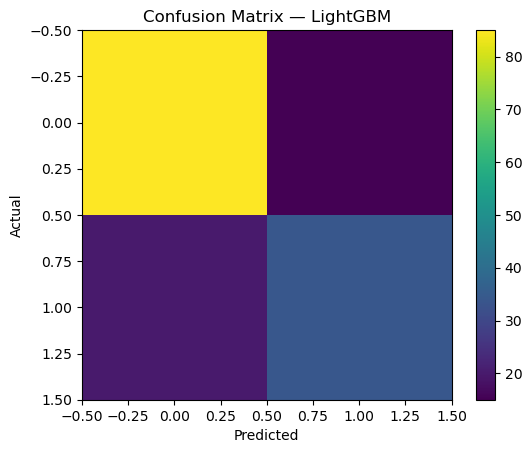

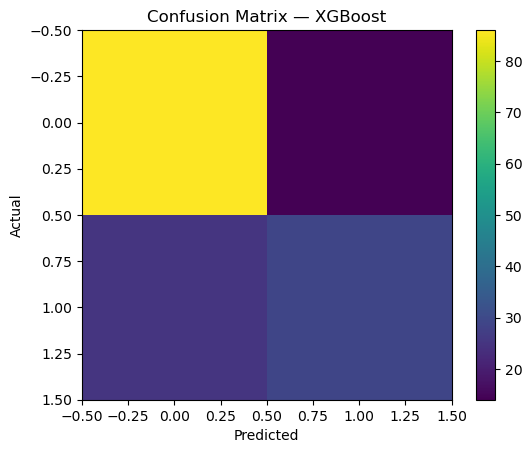

In [41]:
 #Confusion Matrices
plt.figure()
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.imshow(cm_lgb)
plt.title('Confusion Matrix — LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()


plt.figure()
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.imshow(cm_xgb)
plt.title('Confusion Matrix — XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()

In [43]:
# Comparative Analysis

comparison = pd.DataFrame({
'Model': ['LightGBM', 'XGBoost'],
'Accuracy': [accuracy_score(y_test, y_pred_lgb), accuracy_score(y_test, y_pred_xgb)],
'Precision': [precision_score(y_test, y_pred_lgb), precision_score(y_test, y_pred_xgb)],
'Recall': [recall_score(y_test, y_pred_lgb), recall_score(y_test, y_pred_xgb)],
'F1': [f1_score(y_test, y_pred_lgb), f1_score(y_test, y_pred_xgb)]
})

print(comparison)


      Model  Accuracy  Precision    Recall        F1
0  LightGBM  0.772727   0.693878  0.629630  0.660194
1   XGBoost  0.746753   0.674419  0.537037  0.597938


In [ ]:
# Explaination
# - LightGBM and XGBoost both perform well on this dataset.
# - Compare metrics to see which model is stronger in recall or precision.
# - Strengths: fast training, handles numeric features well.
# - Weaknesses: sensitive to hyperparameters; cross-validation recommended.